In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib import image
import os

In [2]:
#load images of size 112,92

train_image_list=[]
test_image_list=[]
for i in range(1,41):
    j=1
    s = os.listdir('s'+str(i)+'/')
     
    for image in s:
        if(j<=6):
            im = Image.open('s'+str(i)+'/' + image)
            train_image_list.append(np.asarray(im).flatten())
        else:
            im = Image.open('s'+str(i)+'/' + image)
            test_image_list.append(np.asarray(im).flatten())
        j+=1


## Training 

In [3]:
# 1. Generate the face dataset for training (60%)

#Face_Db = image_list[:,0:6]
Face_Db = np.array(train_image_list).T
print(Face_Db.shape)

(10304, 240)


In [4]:
# 2. Mean Calculation

mn,p = Face_Db.shape
M = np.zeros((mn,1))
for i in range(mn):
        for j in range(p):
            M[i] += Face_Db[i][j]
        M[i] /= p
print(M.shape)

(10304, 1)


In [5]:
# 3. Do mean Zero

delt = np.zeros((mn,p))
for i in range(mn):
    for j in range(p):
        delt[i][j]=Face_Db[i][j]-M[i]

In [6]:
# 4. Cov of mean aligned faces (delt)
def cov(d):
    row,col=d.shape
    covm = np.zeros((col,col))        
    for z in range(col):
        for y in range(col):
            covm[z][y] = (1/row) * np.dot(d[:,y].T,d[:,z])                   
    return covm


In [7]:
cov_matrix = cov(delt)
print(cov_matrix.shape)

(240, 240)


In [8]:
# 5. Do eigenvalue and eigenvector decomposition (sorted)

eigenValues, eigenVectors = np.linalg.eig(cov_matrix)
idx = eigenValues.argsort()[::-1]   
eigen_val = eigenValues[idx]
eigen_vector = eigenVectors[:,idx]
eigen_val = np.diag(eigen_val)
print("...Eigen Values...")
print(eigen_val.shape)
print()
print("...Eigen Vector...")
print(eigen_vector.shape)

...Eigen Values...
(240, 240)

...Eigen Vector...
(240, 240)


In [9]:
# 6. Find the best direction (Generation of feature vectors)

k=30
Feature_vector = eigen_vector[:,0:k]
print(Feature_vector.shape)

(240, 30)


In [10]:
# 7. Generating Eigenfaces

Eigen_faces = np.dot(Feature_vector.T,delt.T)
print(Eigen_faces.shape)

(30, 10304)


In [11]:
# 8. Generate Signature of Each Face

Signature = np.dot(Eigen_faces,delt)
print(Signature.shape)

(30, 240)


## Test

In [12]:
# 1. Make image list as a column vector

#print(len(test_image_list))
test1 = np.array(test_image_list[20])
print(test1.shape)

(10304,)


In [13]:
# 2. Do mean Zero
Mean_zero=np.zeros(len(test1))
for i in range(len(test1)):
    Mean_zero[i] = test1[i] - M[i]
    
print(Mean_zero.shape)

(10304,)


In [14]:
# 3. Projected test face (signature)

project = np.dot(Eigen_faces,Mean_zero)
print(project.shape)

(30,)


In [15]:
# 4. Euclidean distance between projected test face & signature of each face

def euclidean_dist(x1,x2):
    dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5
    return dist

In [16]:
min_dist = 999999999

project_t=project.T
Signature_t=Signature.T

for i in range(len(project_t)):   
    dist=euclidean_dist(Signature[i],project)
    if(dist<min_dist):
        min_dist=dist
        label=i
    i+=1
    label=(label//6)+1 
    
print(label)

1


In [17]:
def accuracy_rate(X,Y):
    correct_count = 0
    for i in range(len(X)):
        if(X[i] == Y[i]):
            correct_count = correct_count + 1
    accuracy_val = (correct_count/len(X))*100
    return accuracy_val

In [20]:
# true labels

trueLabels = np.arange(0,160)
trueLabels = (trueLabels//4)

accuracy_curve = []

Test_Face_Db = np.array(test_image_list).T 

# step 2 mean 0 for testing
Iota_2 = np.zeros((Test_Face_Db.shape))
mn,q = Test_Face_Db.shape

for i in range(mn):
    for j in range(q):
        Iota_2[i][j] = Test_Face_Db[i][j] - M[i]

Omega = np.dot(Eigen_faces,Iota_2)

# column wise minimum distance calculation
    # transposing both of them will makes things easier
Omega_T = Omega.T
omega_T = Signature.T

for k in range(0,31):

    #psi = eigen_vector[:,0:k]

    # step 7 Generate Eigen Faces
    #phi = np.dot(psi.T,delt.T)

    # step 8 Generate Signature
    #omega = np.dot(phi,delt)

    # minimum distance
    min_dist = 999999999

    distances = [0]*q
    classes = [0]*q

    i = 0
    for sign_test in Omega_T:
        j = 0
        for sign_train in omega_T:
            dist = euclidean_dist(sign_test[0:k],sign_train[0:k])
            if(dist < min_dist):
                min_dist = dist
                label = j
            j+=1

        distances[i] = min_dist
        classes[i] = (label//6) # each person testset contains 4 images
        i+=1
        min_dist = 99999999

    accuracy = accuracy_rate(trueLabels,classes)
    accuracy_curve.append(accuracy)

[2.5, 13.125, 36.875, 56.875, 71.875, 76.875, 81.875, 86.875, 86.25, 88.125, 88.75, 89.375, 90.0, 90.0, 90.625, 90.625, 91.25, 91.25, 91.875, 91.875, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5, 92.5]


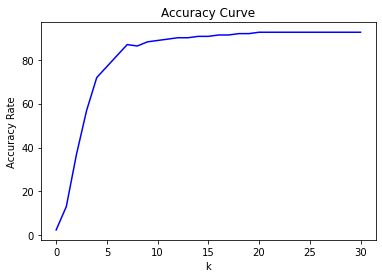

In [21]:
plt.plot(np.arange(0,31), accuracy_curve, color ="blue")  
plt.title("Accuracy Curve")  
plt.xlabel("k")  
plt.ylabel("Accuracy Rate") 
plt.show()